# Lotka–Volterra Case Study

## Data source:
This example only uses simulated dataset to show the efficacy of InvODE.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sys
import scipy.io

In [2]:
# Get path to MCMCwithODEs_primer (3 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..','..','..'))
sys.path.insert(0, project_root)


In this example, we simulate the classic Lotka-Volterra model using chosen values of parameter set, add additive Gaussian noise to the time series and treat this in-silico time series as raw data for pointwise inference.
The model of prey, $x$ and predator $y$ is given by,
$$
\frac{dx}{dt} = \alpha x  -\beta xy
$$
$$
\frac{dy}{dt} = \delta xy  -\gamma y
$$

In [3]:
def lotka_volterra(z, t, params):
    x, y = z
    alpha = params['alpha']
    beta = params['beta']
    delta = params['delta']
    gamma = params['gamma']
    
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]



In [4]:
true_params = {
    'alpha': 1.0,    # prey growth rate
    'beta': 0.1,     # predation rate
    'delta': 0.075,  # predator growth per prey eaten
    'gamma': 1.5     # predator death rate
}

t = np.linspace(0, 20, 200)
z0 = [40, 9]  # initial population: 40 prey, 9 predators


In [5]:
true_sol = odeint(lotka_volterra, z0, t, args=(true_params,))
noisy_data = true_sol + np.random.normal(0, 1.0, true_sol.shape)


## Fitting the dataset with InvODE

In [6]:
def simulate_model(params):
    sol = odeint(lotka_volterra, z0, t, args=(params,))
    return sol  # shape: (N, 2)

def mse(output):
    return np.mean((output - noisy_data)**2)

In this example, we show that only a wide parameter bound is sufficient to infer parameters. Unlike many other packages, we do not need to provide an initial guess. The paramter range is kept wide intentionally for demonstration.

In [7]:
param_bounds = {
    'alpha': (0.5, 10),
    'beta': (0.05, 0.9),
    'delta': (0.05, 0.9),
    'gamma': (1.0, 5.0)
}


In [8]:
import sys
sys.path.append('./..')  # or absolute path if needed

from invode import ODEOptimizer, lhs_sample

In [9]:
# Run optimizer
optimizer = ODEOptimizer(
    ode_func=simulate_model,
    error_func=mse,
    param_bounds=param_bounds,
    seed=42,
    num_top_candidates=3
)





In [10]:

optimizer.fit()


Fitting Progress: 100%|█████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


Refining params: {'alpha': 0.5483310416214465, 'beta': 0.068028770810073, 'delta': 0.1451018918331013, 'gamma': 3.1481636450536428}
Refining params: {'alpha': 0.8216385700908369, 'beta': 0.12479204383819222, 'delta': 0.0616377161233344, 'gamma': 1.615577581450748}
Refining params: {'alpha': 1.088028953494527, 'beta': 0.24201471359553078, 'delta': 0.10339353925892915, 'gamma': 1.6535395505316968}


({'alpha': 0.9998973552849139,
  'beta': 0.09995621865139477,
  'delta': 0.07482275016126995,
  'gamma': 1.4972199684549248},
 0.9454500024300705)

In [11]:
optimizer.summary()

🔍 ODEOptimizer Summary:
  ode_func: simulate_model
  error_func: mse
  param_bounds: {'alpha': (0.5, 10), 'beta': (0.05, 0.9), 'delta': (0.05, 0.9), 'gamma': (1.0, 5.0)}
  initial_guess: {'alpha': 5.25, 'beta': 0.47500000000000003, 'delta': 0.47500000000000003, 'gamma': 3.0}
  n_samples: 100
  num_iter: 10
  num_top_candidates: 3
  do_local_opt: True
  local_method: L-BFGS-B
  shrink_rate: 0.5
  parallel: False
  local_parallel: False
  verbose: False
  verbose_plot: False
  seed: 42
  best_error: 0.9454500024300705
  best_params: {'alpha': 0.9998973552849139, 'beta': 0.09995621865139477, 'delta': 0.07482275016126995, 'gamma': 1.4972199684549248}


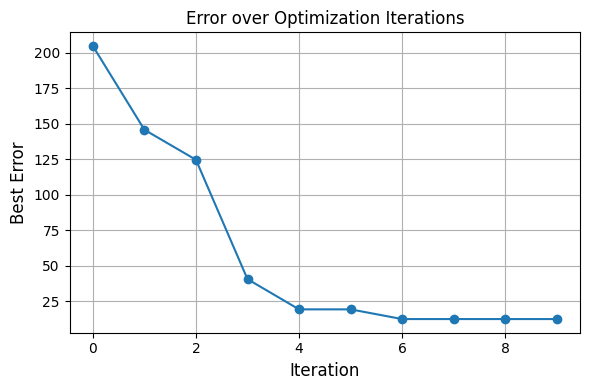

In [12]:
optimizer.plot_error_history()

In [13]:
optimizer.best_params

{'alpha': 0.9998973552849139,
 'beta': 0.09995621865139477,
 'delta': 0.07482275016126995,
 'gamma': 1.4972199684549248}

In [14]:
optimizer.best_error

0.9454500024300705

In [15]:
history = optimizer.get_top_candidates_history()

# Example: print best candidate from each iteration
for i, candidates in enumerate(history):
    print(f"Iteration {i+1}: Best error = {candidates[0][1]:.4f}")

Iteration 1: Best error = 204.6680
Iteration 2: Best error = 145.7022
Iteration 3: Best error = 124.5489
Iteration 4: Best error = 40.5091
Iteration 5: Best error = 19.2365
Iteration 6: Best error = 51.9826
Iteration 7: Best error = 12.4050
Iteration 8: Best error = 32.4487
Iteration 9: Best error = 50.0270
Iteration 10: Best error = 26.6829


If we wanted to explore what parameters were sampled and chosen on the way towards optimization, we can dig into it.

In [16]:
df = optimizer.get_top_candidates_table()
print(df)

    iteration  rank       error     alpha      beta     delta     gamma
0           1     1  204.667960  4.635283  0.548670  0.272194  3.750834
1           1     2  218.967236  3.948483  0.639474  0.266935  3.296262
2           1     3  224.830375  3.143117  0.334123  0.277048  2.619616
3           2     1  145.702157  6.541759  0.669410  0.176117  3.965542
4           2     2  150.452967  3.694805  0.448981  0.095968  2.381629
5           2     3  151.425265  4.592497  0.524295  0.146545  3.973435
6           3     1  124.548898  1.667789  0.482981  0.145486  1.406716
7           3     2  126.479216  3.239774  0.298372  0.075456  1.800184
8           3     3  139.599956  4.021883  0.458061  0.139802  3.099533
9           4     1   40.509116  1.501547  0.157396  0.096360  1.188872
10          4     2   67.987344  1.113214  0.313581  0.092433  1.601306
11          4     3  108.088022  1.100925  0.343522  0.162367  2.142834
12          5     1   19.236542  1.221271  0.188816  0.071793  1

In [17]:
best_params = optimizer.best_params


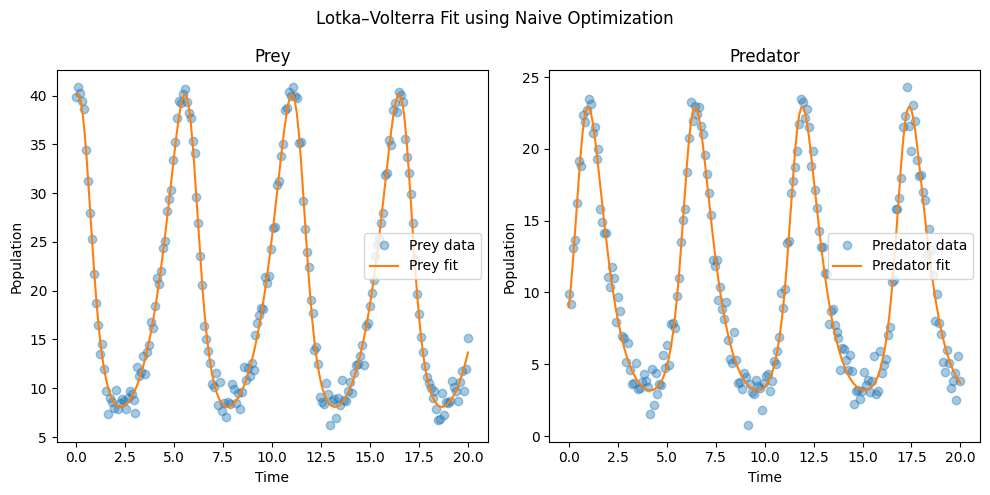

In [18]:
best_fit = simulate_model(best_params)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, noisy_data[:, 0], 'o', alpha=0.4, label='Prey data')
plt.plot(t, best_fit[:, 0], label='Prey fit')
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Prey")

plt.subplot(1, 2, 2)
plt.plot(t, noisy_data[:, 1], 'o', alpha=0.4, label='Predator data')
plt.plot(t, best_fit[:, 1], label='Predator fit')
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Predator")

plt.suptitle("Lotka–Volterra Fit using Naive Optimization")
plt.tight_layout()
plt.show()



In [19]:
from invode import ODESensitivity

In [31]:
sensitivity = ODESensitivity(ode_func=simulate_model,error_func=mse)

In [32]:
sensitivities = sensitivity.analyze_parameter_sensitivity(df)

In [33]:
# Identify most consistently sensitive parameters
summary['mean_abs_sensitivity'] = summary.abs().mean(axis=1)
print(summary.sort_values('mean_abs_sensitivity', ascending=False))

       correlation  rank_correlation  variance  mutual_info  \
beta      1.000000          1.000000  0.837219     1.000000   
alpha     0.939654          0.821020  0.705869     0.890829   
delta     0.882231          0.691107  1.000000     0.528090   
gamma     0.739286          0.660998  0.000000     0.000000   

       mean_abs_sensitivity  
beta               0.959305  
alpha              0.839343  
delta              0.775357  
gamma              0.350071  
